<a href="https://colab.research.google.com/github/RiccardoSturla/Image-classifier-MvsC/blob/main/MuffinvsChihuahua.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Muffins and Chihuahuas image classifier**
Riccardo Sturla 13457A

# Connecting to Drive and importing libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.8 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras import activations, layers, optimizers, losses, regularizers
import pandas as pd
import random
import pickle
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
import keras_tuner as kt
from tensorflow import random as tf_random
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from sklearn import metrics
import seaborn as sns

from sklearn.metrics import zero_one_loss
from sklearn.model_selection import KFold, cross_val_score

# Load Images and Splitting the dataset

Creating a function to plot the results

In [5]:
def ct_seed_set():
  np.random.seed(42)
  tf.random.set_seed(42)

In [6]:
def performance_plot(history):
    step=int(len(history.history['loss'])/10)

    plt.figure(figsize=(16, 5))

    # loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], color = 'deepskyblue')
    plt.plot(history.history['val_loss'], color = 'blue')
    plt.ylabel('Loss', size=12)
    plt.xlabel('Epoch', size=12)


    plt.xticks(np.arange(0, len(history.history['loss']), step=step), np.arange(1, len(history.history['loss'])+1, step=step))

    plt.grid(alpha=.25)
    plt.legend(['Train', 'Validation'])
    plt.title("Model Loss")

    # accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], color = 'deepskyblue')
    plt.plot(history.history['val_accuracy'], color = 'blue')
    plt.ylabel('Accuracy', size=12)
    plt.xlabel('Epoch', size=12)
    plt.legend(['Train', 'Validation'])
    plt.title("Model Accuracy")
    plt.grid(alpha=.25)
    plt.xticks(np.arange(0, len(history.history['loss']), step=step), np.arange(1, len(history.history['loss'])+1, step=step))
    plt.show()

In [7]:
# Loading of the images (training set)

ct_seed_set()

datadir="/content/drive/MyDrive/Images/train"
categories=["chihuahua", "muffin"]
IMG_SIZE = 150
training_data=[]
test_data=[]

**Functions to create the sets**

In [8]:
def create_training_data():
    for category in categories:

        path = os.path.join("/content/drive/MyDrive/Images/train",category)  # create path
        class_num = categories.index(category)  # binary classes


        for img in os.listdir(path):

            img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)

            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize

            training_data.append([new_array, class_num])

def create_test_data():
    for category in categories:

        path = os.path.join("/content/drive/MyDrive/Images/test",category)  # create path
        class_num = categories.index(category)  # binary classes

        for img in os.listdir(path):

            img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)

            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize

            test_data.append([new_array, class_num])

create_training_data()

create_test_data()
print(len(training_data))

4743


**Let's have a look at some images**

In [9]:
random.shuffle(training_data)
random.shuffle(test_data)
X_train=[]
y_train=[]

for features,label in training_data:
    X_train.append(features)
    y_train.append(label)
X_train = np.array(X_train).reshape(-1, IMG_SIZE, IMG_SIZE, 1) #convert all the images to gray scale
X_train=X_train/255
y_train=np.array(y_train)

X_test=[]
y_test=[]
for features,label in test_data:
    X_test.append(features)
    y_test.append(label)
X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test=np.array(y_test)
X_test=X_test/255
y_test=np.array(y_test)

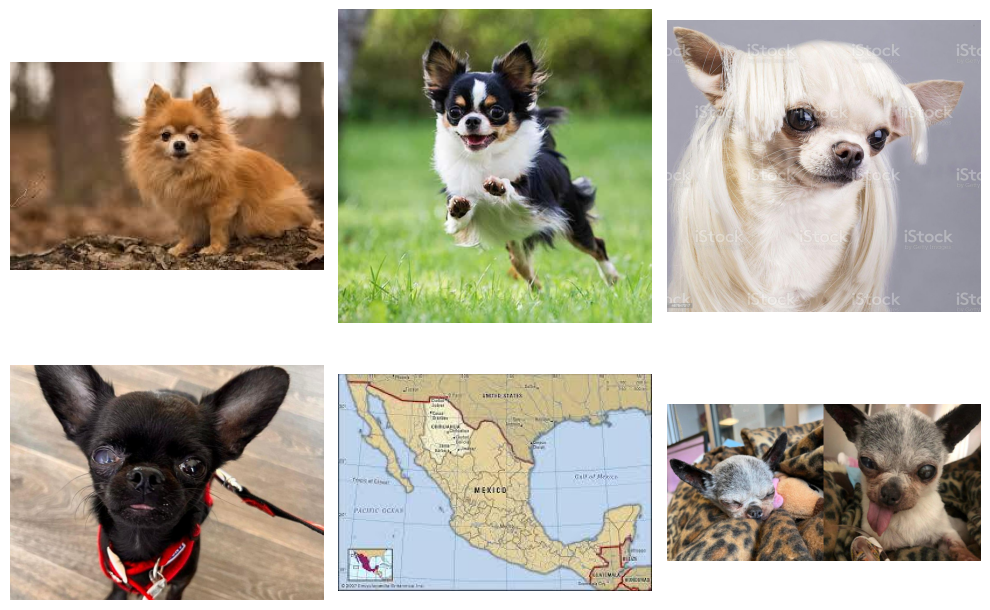

In [ ]:
class_names = ['Chihuahua', 'Muffin']

image_datas = []
path = os.path.join(datadir, 'chihuahua')
for i in range(6):
    image_datas.append(cv2.imread(os.path.join(path, os.listdir(path)[i])))

# Plot the six images
fig, axarr = plt.subplots(2, 3, figsize=(10, 7))
for i in range(6):
    axarr[i//3, i%3].imshow(cv2.cvtColor(image_datas[i], cv2.COLOR_BGR2RGB))
    axarr[i//3, i%3].axis("off")

plt.tight_layout()
plt.show()

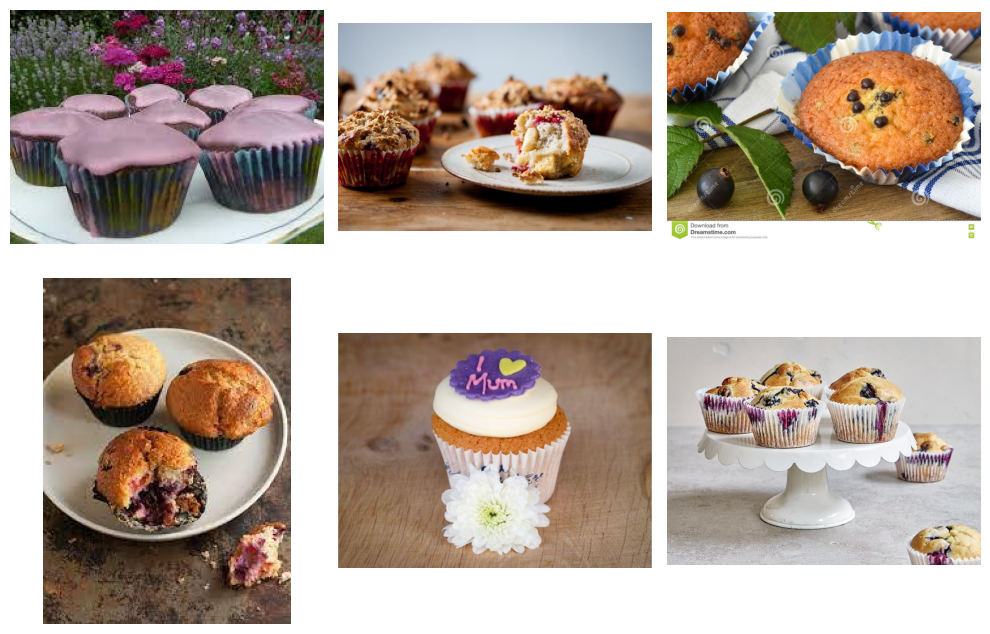

In [ ]:
image_datas = []
path = os.path.join(datadir, 'muffin')
for i in range(6):
    image_datas.append(cv2.imread(os.path.join(path, os.listdir(path)[i])))

# Plot the six images
fig, axarr = plt.subplots(2, 3, figsize=(10, 7))
for i in range(6):
    axarr[i//3, i%3].imshow(cv2.cvtColor(image_datas[i], cv2.COLOR_BGR2RGB))
    axarr[i//3, i%3].axis("off")

plt.tight_layout()
plt.show()

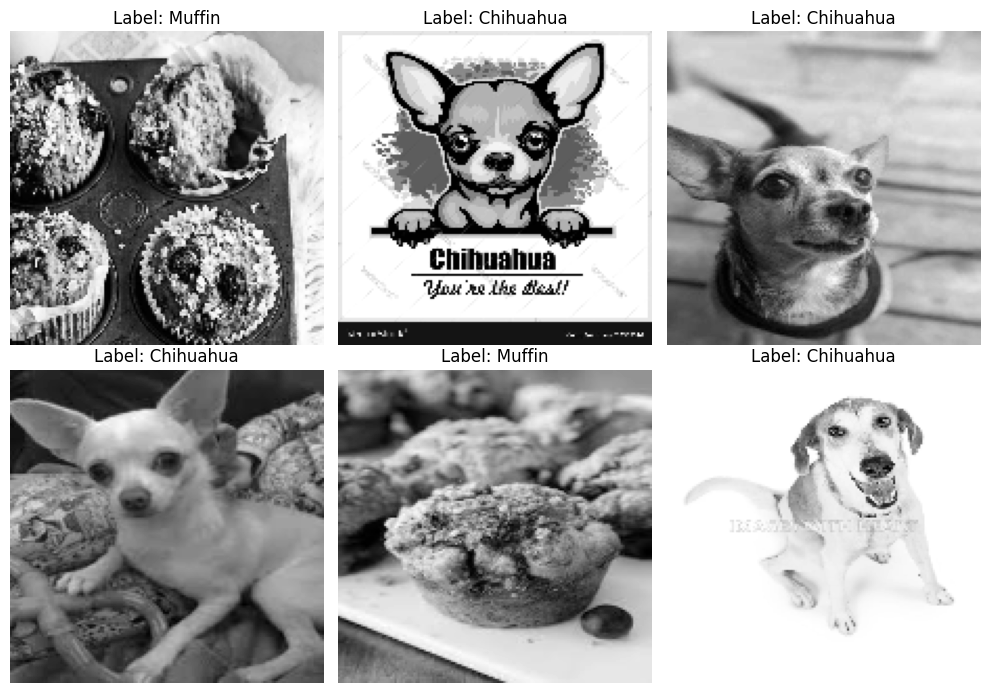

In [ ]:
class_names = ['Chihuahua', 'Muffin']

# Function to plot images

def plot_images(images, labels, class_names, grayscale=False):
    fig, axes = plt.subplots(2, 3, figsize=(10, 7))
    axes = axes.flatten()

    for i in range(6):
        if grayscale:
            axes[i].imshow(images[i], cmap='gray')
        else:
            axes[i].imshow(images[i])

        class_name = class_names[labels[i]]
        axes[i].set_title('Label: {}'.format(class_name))
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


plot_images(X_train[:6].reshape(-1, IMG_SIZE, IMG_SIZE), y_train[:6], class_names, grayscale=True)


# **Base Model**

In [ ]:
ct_seed_set()

model0=Sequential()

model0.add(Conv2D(32,(3,3),activation="relu", input_shape=(150,150,1)))
model0.add(MaxPooling2D(2,2))

model0.add(Conv2D(64,(3,3),activation="relu"))
model0.add(MaxPooling2D(2,2))

model0.add(Conv2D(64,(3,3),activation="relu"))
model0.add(MaxPooling2D(2,2))

model0.add(Flatten())
model0.add(Dense(64, activation="relu"))

model0.add(Dense(1,activation="sigmoid"))

model0.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

Epoch 1/10
134/134 [==============================] - 5s 24ms/step - loss: 0.5780 - accuracy: 0.7052 - val_loss: 0.5513 - val_accuracy: 0.7074
Epoch 2/10
134/134 [==============================] - 3s 20ms/step - loss: 0.4588 - accuracy: 0.7903 - val_loss: 0.4076 - val_accuracy: 0.8084
Epoch 3/10
134/134 [==============================] - 3s 19ms/step - loss: 0.3827 - accuracy: 0.8245 - val_loss: 0.3932 - val_accuracy: 0.8442
Epoch 4/10
134/134 [==============================] - 3s 19ms/step - loss: 0.3114 - accuracy: 0.8639 - val_loss: 0.3726 - val_accuracy: 0.8295
Epoch 5/10
134/134 [==============================] - 3s 20ms/step - loss: 0.2333 - accuracy: 0.9025 - val_loss: 0.4225 - val_accuracy: 0.8211
Epoch 6/10
134/134 [==============================] - 3s 20ms/step - loss: 0.1882 - accuracy: 0.9227 - val_loss: 0.3889 - val_accuracy: 0.8484
Epoch 7/10
134/134 [==============================] - 3s 19ms/step - loss: 0.1369 - accuracy: 0.9445 - val_loss: 0.3568 - val_accuracy: 0.8695

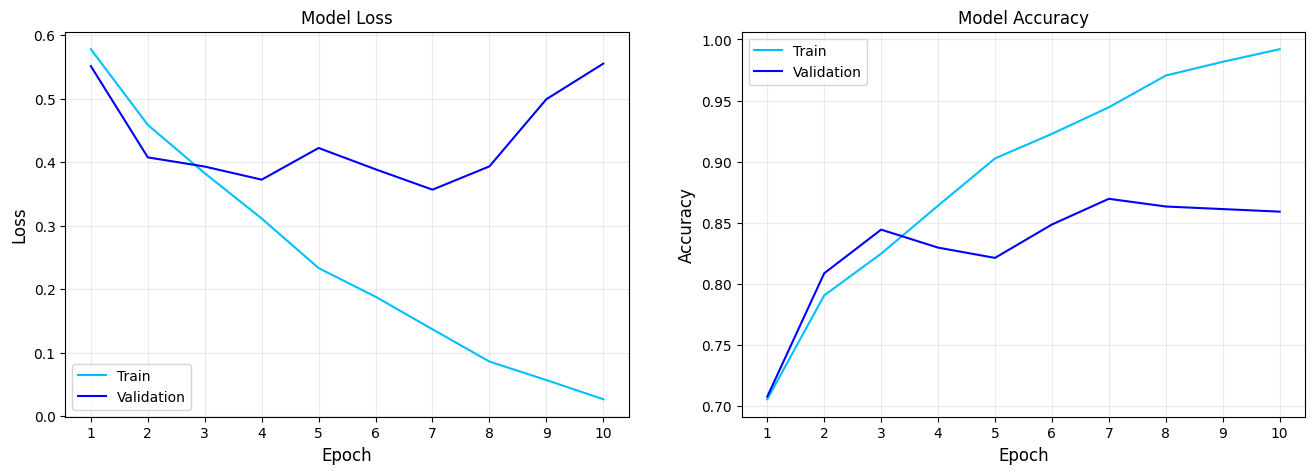

In [ ]:
history0 = model0.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10,
    validation_split=0.1
)
performance_plot(history0)

# *Adding dropout to reduce overfitting*

In [ ]:
ct_seed_set()

model0b=Sequential()

model0b.add(Conv2D(32,(3,3),activation="relu", input_shape=(150,150,1)))
model0b.add(MaxPooling2D(2,2))

model0b.add(Conv2D(64,(3,3),activation="relu"))
model0b.add(MaxPooling2D(2,2))

model0b.add(Conv2D(64,(3,3),activation="relu"))
model0b.add(MaxPooling2D(2,2))
model0b.add(Dropout(0.6))

model0b.add(Flatten())
model0b.add(Dropout(0.6))
model0b.add(Dense(64, activation="relu"))

model0b.add(Dense(1,activation="sigmoid"))

model0b.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model0b.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 17, 17, 64)       

Epoch 1/30
134/134 [==============================] - 8s 38ms/step - loss: 0.6798 - accuracy: 0.5609 - val_loss: 0.5691 - val_accuracy: 0.6905
Epoch 2/30
134/134 [==============================] - 5s 36ms/step - loss: 0.5615 - accuracy: 0.7266 - val_loss: 0.4651 - val_accuracy: 0.8147
Epoch 3/30
134/134 [==============================] - 5s 38ms/step - loss: 0.5123 - accuracy: 0.7662 - val_loss: 0.4734 - val_accuracy: 0.7937
Epoch 4/30
134/134 [==============================] - 5s 36ms/step - loss: 0.4653 - accuracy: 0.7962 - val_loss: 0.3958 - val_accuracy: 0.8358
Epoch 5/30
134/134 [==============================] - 4s 31ms/step - loss: 0.4255 - accuracy: 0.8114 - val_loss: 0.3649 - val_accuracy: 0.8611
Epoch 6/30
134/134 [==============================] - 4s 29ms/step - loss: 0.3957 - accuracy: 0.8250 - val_loss: 0.4285 - val_accuracy: 0.8042
Epoch 7/30
134/134 [==============================] - 4s 28ms/step - loss: 0.3709 - accuracy: 0.8416 - val_loss: 0.3536 - val_accuracy: 0.8505

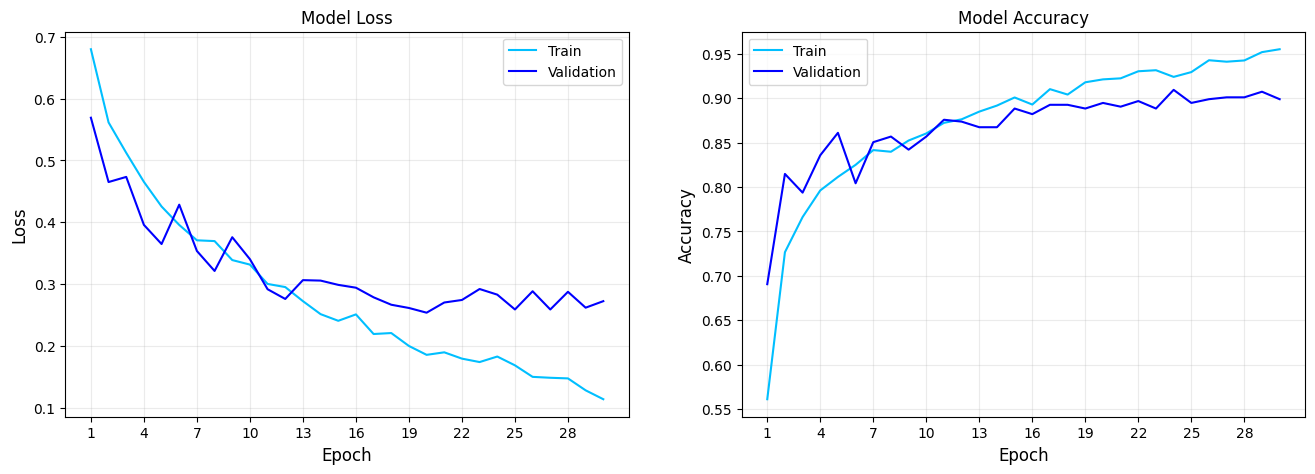

In [ ]:
history0b = model0b.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=30,
    validation_split=0.1
)
performance_plot(history0b)

# Early stopping

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# *Learning rate*

In [ ]:
ct_seed_set()
learning_rate = 0.0005
l2_lambda = 0.0001

model1c=Sequential()

model1c.add(Conv2D(32,(3,3),activation="relu", input_shape=(150,150,1), kernel_regularizer=l2(l2_lambda)))
model1c.add(MaxPooling2D(2,2))

model1c.add(Conv2D(64,(3,3),activation="relu", kernel_regularizer=l2(l2_lambda)))
model1c.add(MaxPooling2D(2,2))

model1c.add(Conv2D(64,(3,3),activation="relu", kernel_regularizer=l2(l2_lambda)))
model1c.add(MaxPooling2D(2,2))
model1c.add(Dropout(0.6))

model1c.add(Flatten())
model1c.add(Dropout(0.6))
model1c.add(Dense(64, activation="relu"))

model1c.add(Dense(1,activation="sigmoid"))

model1c.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=learning_rate), metrics=["accuracy"])

model1c.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 17, 17, 64)       

Epoch 1/30
134/134 [==============================] - 6s 33ms/step - loss: 0.6388 - accuracy: 0.6497 - val_loss: 0.4947 - val_accuracy: 0.7874
Epoch 2/30
134/134 [==============================] - 4s 30ms/step - loss: 0.5094 - accuracy: 0.7657 - val_loss: 0.4334 - val_accuracy: 0.8084
Epoch 3/30
134/134 [==============================] - 4s 29ms/step - loss: 0.4625 - accuracy: 0.7940 - val_loss: 0.4744 - val_accuracy: 0.7895
Epoch 4/30
134/134 [==============================] - 4s 30ms/step - loss: 0.4339 - accuracy: 0.8100 - val_loss: 0.4578 - val_accuracy: 0.8168
Epoch 5/30
134/134 [==============================] - 4s 29ms/step - loss: 0.4144 - accuracy: 0.8191 - val_loss: 0.3938 - val_accuracy: 0.8463
Epoch 6/30
134/134 [==============================] - 4s 28ms/step - loss: 0.3880 - accuracy: 0.8336 - val_loss: 0.4589 - val_accuracy: 0.7789
Epoch 7/30
134/134 [==============================] - 4s 30ms/step - loss: 0.3700 - accuracy: 0.8416 - val_loss: 0.4736 - val_accuracy: 0.7874

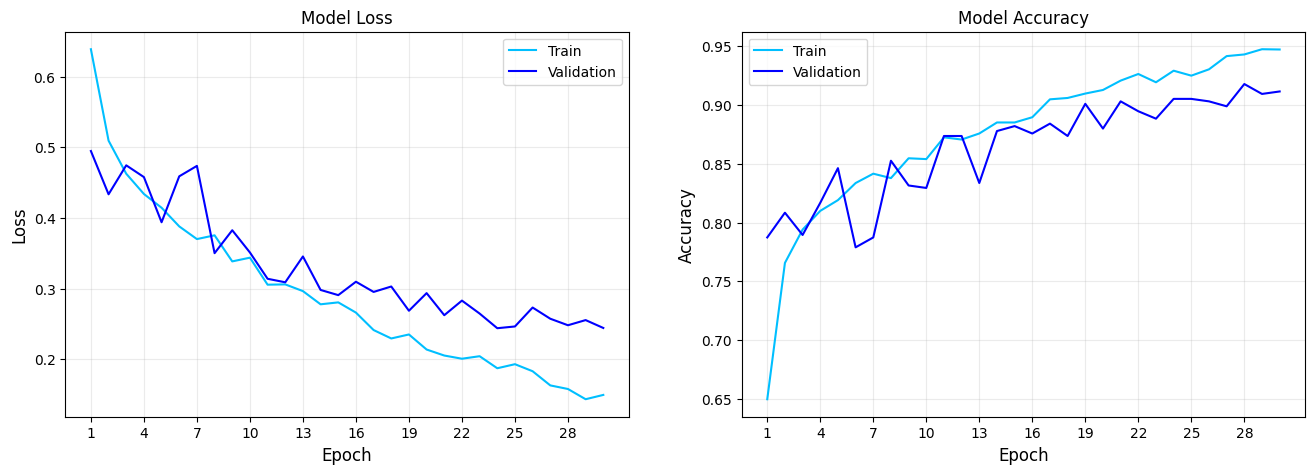

In [ ]:
history1c = model1c.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=30,
    validation_split=0.1,
    callbacks=[early_stopping]
)
performance_plot(history1c)

# *Kernel regularizer and Batch Normalization*

In [46]:
ct_seed_set()
learning_rate = 0.0005
l2_lambda = 0.0001

model1=Sequential()

model1.add(Conv2D(32,(3,3),activation="relu", input_shape=(150,150,1), kernel_regularizer=l2(l2_lambda)))
model1.add(MaxPooling2D(2,2))

model1.add(Conv2D(64,(3,3),activation="relu", kernel_regularizer=l2(l2_lambda)))
model1.add(MaxPooling2D(2,2))

model1.add(Conv2D(128,(3,3),activation="relu", kernel_regularizer=l2(l2_lambda)))
model1.add(MaxPooling2D(2,2))
model1.add(Dropout(0.6))
model1.add(Flatten())
model1.add(Dropout(0.6))

model1.add(Dense(128, activation="relu"))
model1.add(BatchNormalization())
model1.add(Dense(1,activation="sigmoid"))

model1.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=learning_rate), metrics=["accuracy"]) # (learning_rate=learning_rate)

model1.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_84 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_84 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_85 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_85 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_86 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_86 (MaxPooli  (None, 17, 17, 128)     

Epoch 1/28
134/134 [==============================] - 9s 40ms/step - loss: 0.6908 - accuracy: 0.6978 - val_loss: 0.5753 - val_accuracy: 0.7768
Epoch 2/28
134/134 [==============================] - 4s 31ms/step - loss: 0.5010 - accuracy: 0.7798 - val_loss: 0.4829 - val_accuracy: 0.8021
Epoch 3/28
134/134 [==============================] - 4s 33ms/step - loss: 0.4427 - accuracy: 0.8081 - val_loss: 0.5613 - val_accuracy: 0.7116
Epoch 4/28
134/134 [==============================] - 4s 31ms/step - loss: 0.4200 - accuracy: 0.8191 - val_loss: 0.3598 - val_accuracy: 0.8463
Epoch 5/28
134/134 [==============================] - 4s 31ms/step - loss: 0.3847 - accuracy: 0.8372 - val_loss: 0.4379 - val_accuracy: 0.8168
Epoch 6/28
134/134 [==============================] - 4s 32ms/step - loss: 0.3662 - accuracy: 0.8418 - val_loss: 0.3566 - val_accuracy: 0.8632
Epoch 7/28
134/134 [==============================] - 4s 31ms/step - loss: 0.3355 - accuracy: 0.8582 - val_loss: 0.4687 - val_accuracy: 0.8105

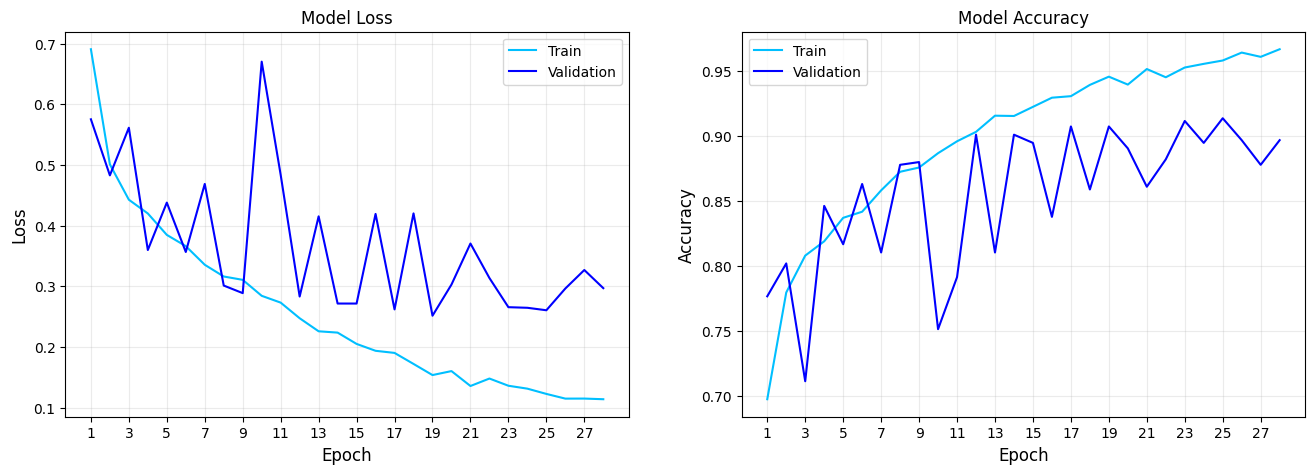

In [47]:
history1 = model1.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=28,
    validation_split=0.1
)
performance_plot(history1)

In [ ]:
ct_seed_set()
learning_rate = 0.0001
l2_lambda = 0.001

model1d=Sequential()

model1d.add(Conv2D(32,(3,3),activation="relu", input_shape=(150,150,1), kernel_regularizer=l2(l2_lambda)))
model1d.add(MaxPooling2D(2,2))

model1d.add(Conv2D(64,(3,3),activation="relu", kernel_regularizer=l2(l2_lambda)))
model1d.add(MaxPooling2D(2,2))

model1d.add(Conv2D(128,(3,3),activation="relu", kernel_regularizer=l2(l2_lambda)))
model1d.add(MaxPooling2D(2,2))
model1d.add(Dropout(0.6))

model1d.add(Flatten())
model1d.add(Dropout(0.6))
model1d.add(Dense(64, activation="relu"))

model1d.add(Dense(1,activation="sigmoid"))

model1d.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=learning_rate), metrics=["accuracy"])

model1d.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 17, 17, 128)      

Epoch 1/40
134/134 [==============================] - 8s 42ms/step - loss: 0.7675 - accuracy: 0.6122 - val_loss: 0.6453 - val_accuracy: 0.7368
Epoch 2/40
134/134 [==============================] - 5s 34ms/step - loss: 0.6453 - accuracy: 0.7252 - val_loss: 0.5722 - val_accuracy: 0.7789
Epoch 3/40
134/134 [==============================] - 4s 33ms/step - loss: 0.5751 - accuracy: 0.7765 - val_loss: 0.5400 - val_accuracy: 0.7789
Epoch 4/40
134/134 [==============================] - 5s 34ms/step - loss: 0.5269 - accuracy: 0.8027 - val_loss: 0.4905 - val_accuracy: 0.8126
Epoch 5/40
134/134 [==============================] - 5s 34ms/step - loss: 0.5104 - accuracy: 0.8067 - val_loss: 0.4909 - val_accuracy: 0.8042
Epoch 6/40
134/134 [==============================] - 4s 33ms/step - loss: 0.4825 - accuracy: 0.8205 - val_loss: 0.4649 - val_accuracy: 0.8295
Epoch 7/40
134/134 [==============================] - 5s 34ms/step - loss: 0.4738 - accuracy: 0.8247 - val_loss: 0.4514 - val_accuracy: 0.8400

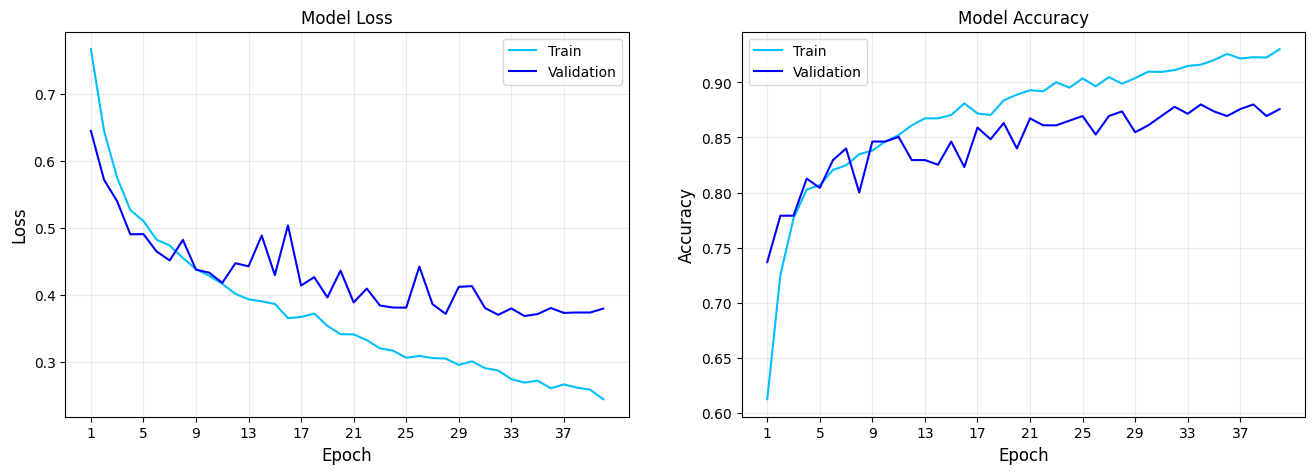

In [ ]:
history1d = model1d.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=40,
    validation_split=0.1,
    callbacks=[early_stopping]
)
performance_plot(history1d)

# **Hyperparamter tuning with Keras Tuner**

In [ ]:
def build_model(hp):

    l2_lambda = 0.0001

    # Learning Rate
    hp_learning_rate = hp.Choice(name="learning_rate",
                                values = [0.0002, 0.001, 0.0005, 0.0001])
    # Dropout Rate
    hp_dropout = hp.Choice(name="dropout",
                                 values = [0, 0.4, 0.5, 0.6, 0.7])

    model1t = Sequential()
    model1t.add(Conv2D(32,(3,3),activation="relu", input_shape=(150,150,1), kernel_regularizer=l2(l2_lambda)))
    model1t.add(MaxPooling2D(2,2))

    model1t.add(Conv2D(64,(3,3),activation="relu", kernel_regularizer=l2(l2_lambda)))
    model1t.add(MaxPooling2D(2,2))

    model1t.add(Conv2D(128,(3,3),activation="relu", kernel_regularizer=l2(l2_lambda)))
    model1t.add(MaxPooling2D(2,2))
    model1t.add(Dropout(hp_dropout))

    model1t.add(Flatten())
    model1t.add(Dropout(hp_dropout))

    model1t.add(Dense(128, activation="relu"))
    model1t.add(BatchNormalization())
    model1t.add(Dense(1,activation="sigmoid"))

    # Compiling the model
    model1t.compile(loss="binary_crossentropy",
                  optimizer=Adam(learning_rate=hp_learning_rate),
                  metrics=["accuracy"])

    return model1t

In [ ]:
tunerX = kt.BayesianOptimization(build_model,
                                objective="val_accuracy",
                                max_trials=10,
                                directory="/content/drive/MyDrive/",
                                project_name="ml_attemptX"
                                )

tunerX.search_space_summary()

In [ ]:
tunerX.search(X_train, y_train,
             batch_size=32,
             epochs=15,
             validation_split=0.1)

In [ ]:
tuner.results_summary()

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters()[0]
best_hyperparameters.values

In [ ]:
from keras_tuner import HyperParameters

def build_modelb(hp):
    l2_lambda = 0.001

    # Learning Rate
    hp_learning_rate = hp.Choice(name="learning_rate",
                                  values=[0.01, 0.005, 0.0025, 0.001, 0.0005, 0.0001])

    # Dropout Rate
    hp_dropout_rate = hp.Float(name="dropout_rate",
                                min_value=0.1,
                                max_value=0.8,
                                step=0.1)

    filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=32)

    model = Sequential()
    model.add(Conv2D(filters,(3,3),activation="relu", input_shape=(150,150,1), kernel_regularizer=l2(l2_lambda)))
    model.add(MaxPooling2D(2,2))

    model.add(Conv2D(filters,(3,3),activation="relu", kernel_regularizer=l2(l2_lambda)))
    model.add(MaxPooling2D(2,2))

    model.add(Conv2D(filters,(3,3),activation="relu", kernel_regularizer=l2(l2_lambda)))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(hp_dropout_rate))

    model.add(Flatten())
    model.add(Dropout(hp_dropout_rate))

    model.add(Dense(64, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dense(1,activation="sigmoid"))

    # Compiling the model
    model.compile(loss="binary_crossentropy",
                  optimizer=Adam(learning_rate=hp_learning_rate),
                  metrics=["accuracy"])

    return model

In [ ]:
tunerb3b = kt.BayesianOptimization(build_modelb,
                                objective="val_accuracy",
                                max_trials=12,
                                directory="/content/drive/MyDrive/",
                                project_name="ml_attempt5"
                                )

tunerb3b.search_space_summary()

In [ ]:
tunerb3b.search(X_train, y_train,
             batch_size=16,
             epochs=14,
             validation_split=0.1)

In [ ]:
tunerb3b.results_summary()

In [21]:
# best
ct_seed_set()
learning_rate_t = 0.0002
l2_lambda = 0.0001

modelt=Sequential()

modelt.add(Conv2D(32,(3,3),activation="relu", input_shape=(150,150,1), kernel_regularizer=l2(l2_lambda)))
modelt.add(MaxPooling2D(2,2))

modelt.add(Conv2D(64,(3,3),activation="relu", kernel_regularizer=l2(l2_lambda)))
modelt.add(MaxPooling2D(2,2))

modelt.add(Conv2D(128,(3,3),activation="relu", kernel_regularizer=l2(l2_lambda)))
modelt.add(MaxPooling2D(2,2))
modelt.add(Dropout(0.6))

modelt.add(Flatten())
modelt.add(Dropout(0.6))
modelt.add(Dense(64, activation="relu"))
modelt.add(BatchNormalization())
modelt.add(Dense(1,activation="sigmoid"))

modelt.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=learning_rate_t), metrics=["accuracy"])

modelt.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_60 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_61 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_61 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_62 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_62 (MaxPooli  (None, 17, 17, 128)     

Epoch 1/40
134/134 [==============================] - 11s 59ms/step - loss: 0.6774 - accuracy: 0.6605 - val_loss: 0.5868 - val_accuracy: 0.8042
Epoch 2/40
134/134 [==============================] - 5s 36ms/step - loss: 0.5269 - accuracy: 0.7612 - val_loss: 0.4991 - val_accuracy: 0.8021
Epoch 3/40
134/134 [==============================] - 4s 33ms/step - loss: 0.4631 - accuracy: 0.7915 - val_loss: 0.4758 - val_accuracy: 0.7958
Epoch 4/40
134/134 [==============================] - 5s 34ms/step - loss: 0.4211 - accuracy: 0.8226 - val_loss: 0.6956 - val_accuracy: 0.6316
Epoch 5/40
134/134 [==============================] - 4s 32ms/step - loss: 0.3895 - accuracy: 0.8388 - val_loss: 0.5235 - val_accuracy: 0.7600
Epoch 6/40
134/134 [==============================] - 4s 33ms/step - loss: 0.3526 - accuracy: 0.8489 - val_loss: 0.4161 - val_accuracy: 0.8105
Epoch 7/40
134/134 [==============================] - 5s 34ms/step - loss: 0.3379 - accuracy: 0.8597 - val_loss: 0.3956 - val_accuracy: 0.840

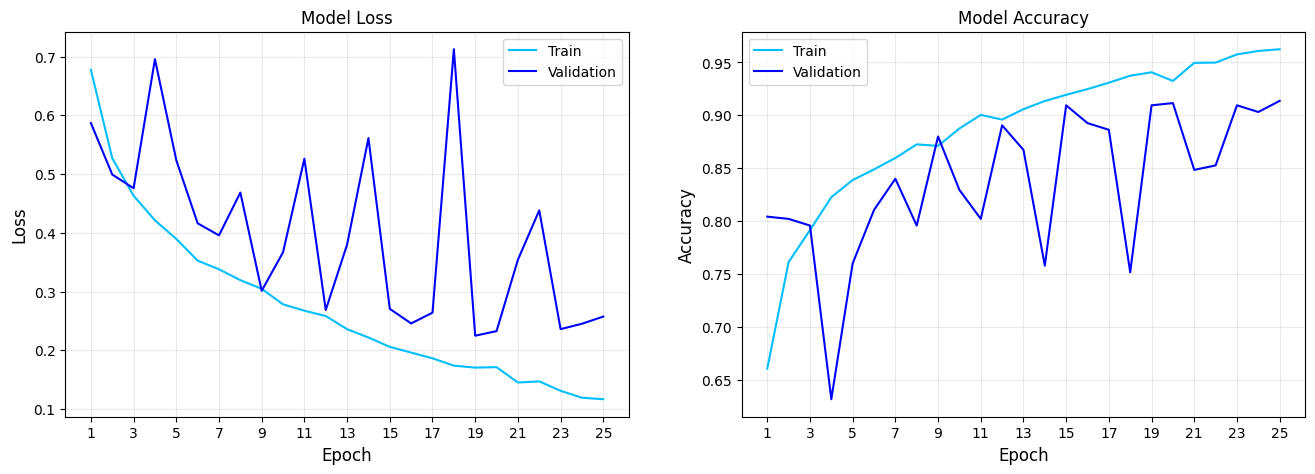

In [22]:
historyt = modelt.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=40,
    validation_split=0.1,
    callbacks=[early_stopping]
)
performance_plot(historyt)

# **Model 2: deeper model**

In [ ]:
ct_seed_set()
learning_rate_t = 0.0005
l2_lambda = 0.001

model_2=Sequential()

model_2.add(Conv2D(32,(3,3),activation="relu", input_shape=(150,150,1), kernel_regularizer=l2(l2_lambda)))
model_2.add(MaxPooling2D(2,2))

model_2.add(Conv2D(64,(3,3),activation="relu", kernel_regularizer=l2(l2_lambda)))
model_2.add(MaxPooling2D(2,2))

model_2.add(Conv2D(128,(3,3),activation="relu", kernel_regularizer=l2(l2_lambda)))
model_2.add(MaxPooling2D(2,2))
model_2.add(Dropout(0.4))

model_2.add(Conv2D(256,(3,3),activation="relu", kernel_regularizer=l2(l2_lambda)))
model_2.add(MaxPooling2D(2,2))
model_2.add(Dropout(0.4))

model_2.add(Conv2D(512,(3,3),activation="relu", kernel_regularizer=l2(l2_lambda)))
model_2.add(MaxPooling2D(2,2))
model_2.add(Dropout(0.4))


model_2.add(Flatten())
model_2.add(Dropout(0.6))
model_2.add(Dense(1024, activation="relu"))
model_2.add(BatchNormalization())

model_2.add(Dense(1,activation="sigmoid"))

model_2.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=learning_rate_t), metrics=["accuracy"])

model_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 17, 17, 128)      

Epoch 1/40
134/134 [==============================] - 10s 44ms/step - loss: 1.5191 - accuracy: 0.5433 - val_loss: 1.2158 - val_accuracy: 0.5768
Epoch 2/40
134/134 [==============================] - 5s 38ms/step - loss: 0.9942 - accuracy: 0.7202 - val_loss: 1.0471 - val_accuracy: 0.5768
Epoch 3/40
134/134 [==============================] - 5s 38ms/step - loss: 0.8104 - accuracy: 0.7863 - val_loss: 0.8582 - val_accuracy: 0.8084
Epoch 4/40
134/134 [==============================] - 5s 36ms/step - loss: 0.7055 - accuracy: 0.8076 - val_loss: 1.0674 - val_accuracy: 0.5768
Epoch 5/40
134/134 [==============================] - 5s 37ms/step - loss: 0.6357 - accuracy: 0.8196 - val_loss: 0.7229 - val_accuracy: 0.7053
Epoch 6/40
134/134 [==============================] - 5s 37ms/step - loss: 0.5582 - accuracy: 0.8416 - val_loss: 1.2634 - val_accuracy: 0.5305
Epoch 7/40
134/134 [==============================] - 5s 37ms/step - loss: 0.5284 - accuracy: 0.8454 - val_loss: 0.4895 - val_accuracy: 0.850

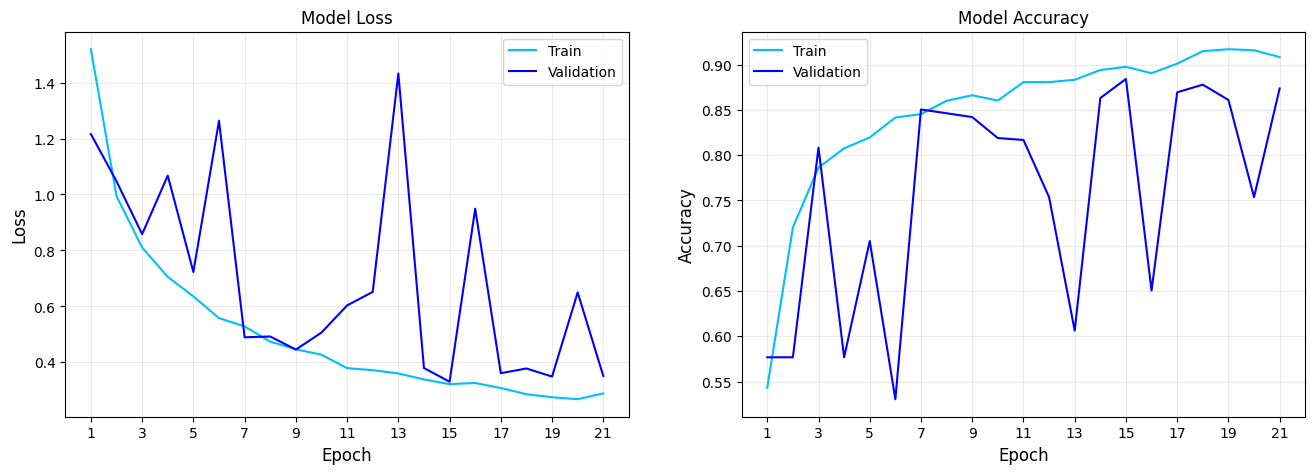

In [ ]:
history_2 = model_2.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=40,
    validation_split=0.1,
    callbacks=[early_stopping]
)
performance_plot(history_2)

# **New Architecture**

In [43]:
ct_seed_set()

learning_rate_t = 0.0005
l2_lambda = 0.0001

model2=Sequential()
model2.add(Conv2D(32,(3,3),activation="relu", padding="same", kernel_regularizer=regularizers.l2(l2_lambda),input_shape=(150,150,1)))
model2.add(MaxPooling2D(2,2))


model2.add(Conv2D(32,(3,3),activation="relu",padding="same", kernel_regularizer=regularizers.l2(l2_lambda)))
model2.add(MaxPooling2D(2,2))

model2.add(Conv2D(64,(3,3),activation="relu", padding="same", kernel_regularizer=regularizers.l2(l2_lambda)))
model2.add(MaxPooling2D(2,2))

model2.add(Conv2D(64,(3,3),activation="relu", padding="same", kernel_regularizer=regularizers.l2(l2_lambda)))
model2.add(MaxPooling2D(2,2))

model2.add(Conv2D(128,(3,3),activation="relu", padding="same", kernel_regularizer=regularizers.l2(l2_lambda)))
model2.add(MaxPooling2D(2,2))
model2.add(Dropout(0.6))

model2.add(Conv2D(128,(3,3),activation="relu", padding="same", kernel_regularizer=regularizers.l2(l2_lambda)))
model2.add(MaxPooling2D(2,2))
model2.add(Dropout(0.6))

model2.add(Flatten())


model2.add(Dense(128, activation="relu", kernel_regularizer=regularizers.l2(l2_lambda)))
model2.add(Dropout(0.7))

model2.add(Dense(64, activation="relu", kernel_regularizer=regularizers.l2(l2_lambda)))

model2.add(Dense(32, activation="relu", kernel_regularizer=regularizers.l2(l2_lambda)))

model2.add(Dense(1,activation="sigmoid"))

model2.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=learning_rate_t), metrics=["accuracy"])

Epoch 1/60
67/67 [==============================] - 7s 64ms/step - loss: 0.7563 - accuracy: 0.5258 - val_loss: 0.7492 - val_accuracy: 0.5600
Epoch 2/60
67/67 [==============================] - 4s 55ms/step - loss: 0.7488 - accuracy: 0.5354 - val_loss: 0.7440 - val_accuracy: 0.5600
Epoch 3/60
67/67 [==============================] - 4s 54ms/step - loss: 0.7429 - accuracy: 0.5351 - val_loss: 0.7390 - val_accuracy: 0.5600
Epoch 4/60
67/67 [==============================] - 4s 57ms/step - loss: 0.7385 - accuracy: 0.5370 - val_loss: 0.7345 - val_accuracy: 0.5600
Epoch 5/60
67/67 [==============================] - 4s 58ms/step - loss: 0.7187 - accuracy: 0.5368 - val_loss: 0.6868 - val_accuracy: 0.6463
Epoch 6/60
67/67 [==============================] - 4s 55ms/step - loss: 0.6762 - accuracy: 0.6457 - val_loss: 0.7086 - val_accuracy: 0.5663
Epoch 7/60
67/67 [==============================] - 4s 56ms/step - loss: 0.6067 - accuracy: 0.7373 - val_loss: 0.5652 - val_accuracy: 0.7495
Epoch 8/60
67

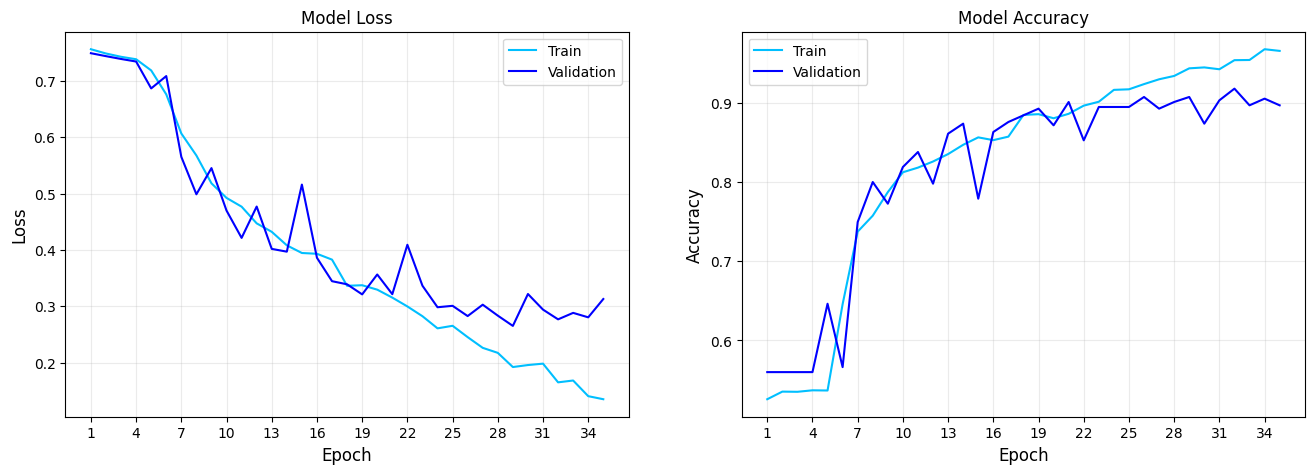

In [44]:
history_130 = model2.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=60,
    validation_split=0.1,
    callbacks=[early_stopping]
)
performance_plot(history_130)

# **Hyperparamters Tuning with KerasTuner**

In [ ]:
def build_modelb2(hp):
    l2_lambda = 0.001

    # Learning Rate
    hp_learning_rate = hp.Choice(name="learning_rate",
                                  values=[0.0002, 0.001, 0.0005, 0.0001])

    # Dropout Rate
    hp_dropout_rate = hp.Float(name="dropout_rate",
                                min_value=0.3,
                                max_value=0.8,
                                step=0.1)

    regularizer = hp.Choice('l2_lambda', values=[0.01, 0.001, 0.0001])

    # filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=32)

    model2=Sequential()
    model2.add(Conv2D(32,(3,3),activation="relu", padding="same", kernel_regularizer=regularizers.l2(regularizer), input_shape=(150,150,1)))

    model2.add(MaxPooling2D(2,2))


    model2.add(Conv2D(32,(3,3),activation="relu",padding="same", kernel_regularizer=regularizers.l2(regularizer)))
    model2.add(MaxPooling2D(2,2))

    model2.add(Conv2D(64,(3,3),activation="relu", padding="same", kernel_regularizer=regularizers.l2(regularizer)))
    model2.add(MaxPooling2D(2,2))

    model2.add(Conv2D(64,(3,3),activation="relu", padding="same", kernel_regularizer=regularizers.l2(regularizer)))
    model2.add(MaxPooling2D(2,2))

    model2.add(Conv2D(128,(3,3),activation="relu", padding="same", kernel_regularizer=regularizers.l2(regularizer)))
    model2.add(MaxPooling2D(2,2))
    model2.add(Dropout(hp_dropout_rate))

    model2.add(Conv2D(128,(3,3),activation="relu", padding="same", kernel_regularizer=regularizers.l2(regularizer)))
    model2.add(MaxPooling2D(2,2))
    model2.add(Dropout(hp_dropout_rate))

    model2.add(Flatten())


    model2.add(Dense(128, activation="relu", kernel_regularizer=regularizers.l2(regularizer)))
    model2.add(Dropout(hp_dropout_rate))

    model2.add(Dense(64, activation="relu", kernel_regularizer=regularizers.l2(regularizer)))
    model2.add(Dense(32, activation="relu", kernel_regularizer=regularizers.l2(regularizer)))
    model2.add(Dense(1,activation="sigmoid"))

    # Compiling the model
    model2.compile(loss="binary_crossentropy",
                  optimizer=Adam(learning_rate=hp_learning_rate),
                  metrics=["accuracy"])

    return model2

In [ ]:
tunerb4b = kt.BayesianOptimization(build_modelb2,
                                objective="val_accuracy",
                                max_trials=12,
                                directory="/content/drive/MyDrive/",
                                project_name="ml_attempt7"
                                )

tunerb4b.search_space_summary()

Reloading Tuner from /content/drive/MyDrive/ml_attempt7/tuner0.json
Search space summary
Default search space size: 3
learning_rate (Choice)
{'default': 0.0002, 'conditions': [], 'values': [0.0002, 0.001, 0.0005, 0.0001], 'ordered': True}
dropout_rate (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.3, 'max_value': 0.8, 'step': 0.1, 'sampling': 'linear'}
l2_lambda (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
tunerb4b.search(X_train, y_train,
             batch_size=32,
             epochs=14,
             validation_split=0.1)

Trial 12 Complete [00h 01m 04s]
val_accuracy: 0.8315789699554443

Best val_accuracy So Far: 0.8357895016670227
Total elapsed time: 1d 04h 52m 24s


In [ ]:
tunerb4b.results_summary()

Results summary
Results in /content/drive/MyDrive/ml_attempt7
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 07 summary
Hyperparameters:
learning_rate: 0.0002
dropout_rate: 0.6000000000000001
l2_lambda: 0.0001
Score: 0.8357895016670227

Trial 11 summary
Hyperparameters:
learning_rate: 0.0002
dropout_rate: 0.6000000000000001
l2_lambda: 0.0001
Score: 0.8315789699554443

Trial 05 summary
Hyperparameters:
learning_rate: 0.0001
dropout_rate: 0.6000000000000001
l2_lambda: 0.0001
Score: 0.8126316070556641

Trial 00 summary
Hyperparameters:
learning_rate: 0.0001
dropout_rate: 0.5
l2_lambda: 0.001
Score: 0.7831578850746155

Trial 02 summary
Hyperparameters:
learning_rate: 0.001
dropout_rate: 0.6000000000000001
l2_lambda: 0.01
Score: 0.5431578755378723

Trial 03 summary
Hyperparameters:
learning_rate: 0.0005
dropout_rate: 0.6000000000000001
l2_lambda: 0.001
Score: 0.5431578755378723

Trial 04 summary
Hyperparameters:
learning_rate: 0.0001
dropout_rate: 0.5
l2_lambd

# **KerasTuner Model**

In [37]:
ct_seed_set()

learning_rate_t = 0.0002
l2_lambda = 0.001

model2c=Sequential()
model2c.add(Conv2D(32,(3,3),activation="relu", padding="same", input_shape=(150,150,1)))
model2c.add(MaxPooling2D(2,2))


model2c.add(Conv2D(32,(3,3),activation="relu",padding="same"))
model2c.add(MaxPooling2D(2,2))

model2c.add(Conv2D(64,(3,3),activation="relu", padding="same",kernel_regularizer=regularizers.l2(0.0001)))
model2c.add(MaxPooling2D(2,2))

model2c.add(Conv2D(64,(3,3),activation="relu", padding="same",kernel_regularizer=regularizers.l2(0.0001)))
model2c.add(MaxPooling2D(2,2))

model2c.add(Conv2D(128,(3,3),activation="relu", padding="same", kernel_regularizer=regularizers.l2(0.0001)))
model2c.add(MaxPooling2D(2,2))
model2c.add(Dropout(0.6))

model2c.add(Conv2D(128,(3,3),activation="relu", padding="same", kernel_regularizer=regularizers.l2(0.0001)))
model2c.add(MaxPooling2D(2,2))
model2c.add(Dropout(0.6))

model2c.add(Flatten())


model2c.add(Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.0001)))
model2c.add(Dropout(0.6))

model2c.add(Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.0001)))

model2c.add(Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.0001)))

model2c.add(Dense(1,activation="sigmoid"))

model2c.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=learning_rate_t), metrics=["accuracy"])

Epoch 1/40
134/134 [==============================] - 7s 32ms/step - loss: 0.7327 - accuracy: 0.5115 - val_loss: 0.7258 - val_accuracy: 0.5600
Epoch 2/40
134/134 [==============================] - 4s 28ms/step - loss: 0.7250 - accuracy: 0.5370 - val_loss: 0.7208 - val_accuracy: 0.5600
Epoch 3/40
134/134 [==============================] - 4s 31ms/step - loss: 0.7218 - accuracy: 0.5351 - val_loss: 0.7184 - val_accuracy: 0.5600
Epoch 4/40
134/134 [==============================] - 4s 30ms/step - loss: 0.7035 - accuracy: 0.5637 - val_loss: 0.6708 - val_accuracy: 0.6568
Epoch 5/40
134/134 [==============================] - 4s 30ms/step - loss: 0.6114 - accuracy: 0.7146 - val_loss: 0.5594 - val_accuracy: 0.7263
Epoch 6/40
134/134 [==============================] - 4s 32ms/step - loss: 0.5392 - accuracy: 0.7685 - val_loss: 0.5694 - val_accuracy: 0.7158
Epoch 7/40
134/134 [==============================] - 4s 30ms/step - loss: 0.5113 - accuracy: 0.7793 - val_loss: 0.5420 - val_accuracy: 0.7368

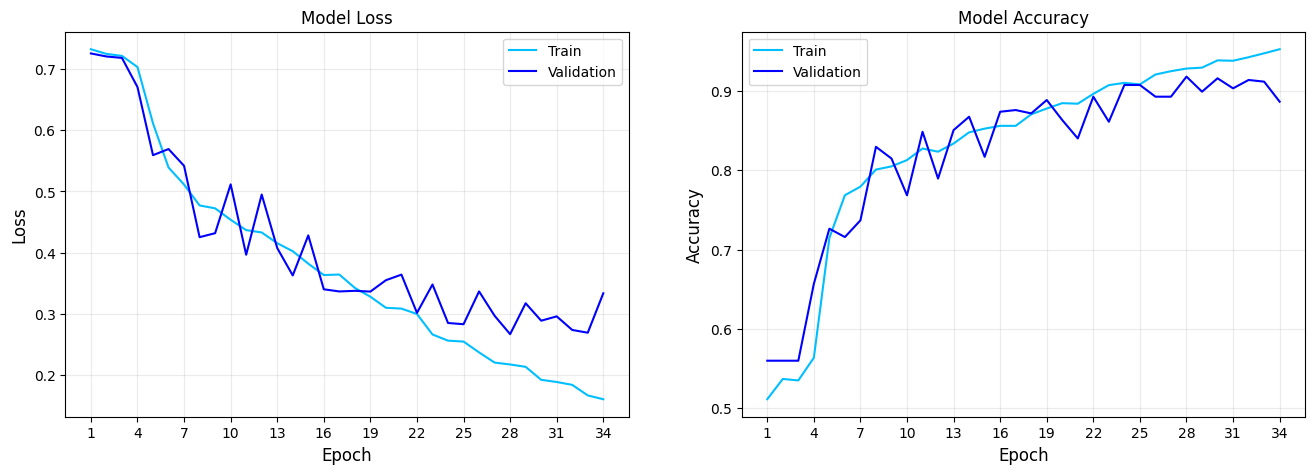

In [38]:
history_130d = model2c.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=40,
    validation_split=0.1,
    callbacks=[early_stopping]
)
performance_plot(history_130d)

# **Model evaluation**

In [39]:
model2c.evaluate(X_test, y_test)

37/37 [==============================] - 0s 8ms/step - loss: 0.2732 - accuracy: 0.9113


[0.27322569489479065, 0.9113175868988037]

In [1]:
# model2c.save("/content/drive/MyDrive/modelf.h5")

NameError: name 'load_model' is not defined

In [11]:
model2c = load_model("/content/drive/MyDrive/modelf.h5")

**Confusion Matrix**

In [13]:
y_pred = model2c.predict(X_test)

y_pred_labels = np.round(y_pred).astype(int).reshape(-1)

incorrect_indices = np.nonzero(y_pred_labels != y_test)[0]

37/37 [==============================] - 4s 12ms/step


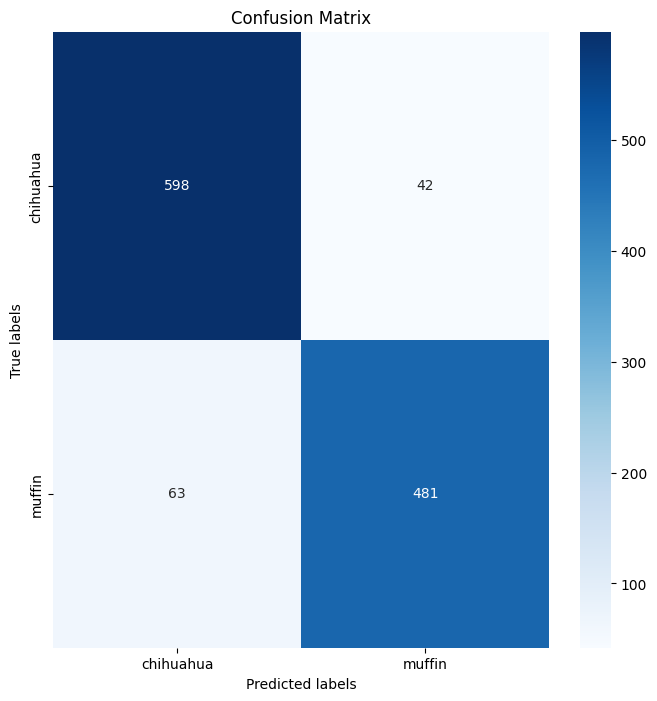

In [14]:
from sklearn.metrics import confusion_matrix

y_pred_labels = np.round(y_pred).astype(int).reshape(-1)
conf_mat = confusion_matrix(y_test, y_pred_labels)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=['chihuahua', 'muffin'], yticklabels=['chihuahua', 'muffin'])
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

# **5-fold Cross Validation**

In [18]:
accuracy_lists=[]
zero_one_loss_lists=[]

k_fold=KFold(n_splits=5, shuffle=True, random_state=42)
index=1
for train_index,test_index in k_fold.split(X_train):
  #subset the training into training and validation
  X_train_cv2, X_val_cv2 = X_train[train_index],X_train[test_index]
  y_train_cv2, y_val_cv2 = y_train[train_index],y_train[test_index]

  print("\n Cycle nr: " + str(index))

  learning_rate_t = 0.0002
  l2_lambda = 0.001

  modelcv2=Sequential()
  modelcv2.add(Conv2D(32,(3,3),activation="relu", padding="same", input_shape=(150,150,1)))
  modelcv2.add(MaxPooling2D(2,2))


  modelcv2.add(Conv2D(32,(3,3),activation="relu",padding="same"))
  modelcv2.add(MaxPooling2D(2,2))

  modelcv2.add(Conv2D(64,(3,3),activation="relu", padding="same",kernel_regularizer=regularizers.l2(0.0001)))
  modelcv2.add(MaxPooling2D(2,2))

  modelcv2.add(Conv2D(64,(3,3),activation="relu", padding="same",kernel_regularizer=regularizers.l2(0.0001)))
  modelcv2.add(MaxPooling2D(2,2))

  modelcv2.add(Conv2D(128,(3,3),activation="relu", padding="same", kernel_regularizer=regularizers.l2(0.0001)))
  modelcv2.add(MaxPooling2D(2,2))
  modelcv2.add(Dropout(0.6))

  modelcv2.add(Conv2D(128,(3,3),activation="relu", padding="same", kernel_regularizer=regularizers.l2(0.0001)))
  modelcv2.add(MaxPooling2D(2,2))
  modelcv2.add(Dropout(0.6))

  modelcv2.add(Flatten())


  modelcv2.add(Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.0001)))
  modelcv2.add(Dropout(0.6))

  modelcv2.add(Dense(64, activation="relu"))

  modelcv2.add(Dense(1,activation="sigmoid"))

  modelcv2.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=learning_rate_t), metrics=["accuracy"])


  hist = modelcv2.fit(
  x=X_train_cv2,
  y=y_train_cv2,
  epochs=40,
  batch_size=32,
  validation_data=(X_val_cv2, y_val_cv2),
  shuffle=True,
  callbacks=[early_stopping]
  )

  loss,accuracy = modelcv2.evaluate(X_val_cv2,y_val_cv2)
  zero_one_loss = 1-accuracy
  zero_one_loss_lists.append(zero_one_loss)
  accuracy_lists.append(accuracy)

  index+=1

print('0-1 Losses:',zero_one_loss_lists)
avg_losss = np.mean(zero_one_loss_lists)
print("Zero-One Loss: {}".format(avg_losss))
print('Accuracies:',accuracy_lists)
avg_accs = np.mean(accuracy_lists)
print("AVG Accuracy: {}".format(avg_accs))


 Cycle nr: 1
Epoch 1/40
119/119 [==============================] - 8s 37ms/step - loss: 0.7314 - accuracy: 0.5271 - val_loss: 0.7275 - val_accuracy: 0.5374
Epoch 2/40
119/119 [==============================] - 4s 31ms/step - loss: 0.7258 - accuracy: 0.5403 - val_loss: 0.7234 - val_accuracy: 0.5374
Epoch 3/40
119/119 [==============================] - 4s 31ms/step - loss: 0.7203 - accuracy: 0.5406 - val_loss: 0.7097 - val_accuracy: 0.5374
Epoch 4/40
119/119 [==============================] - 4s 31ms/step - loss: 0.6860 - accuracy: 0.6104 - val_loss: 0.6066 - val_accuracy: 0.7134
Epoch 5/40
119/119 [==============================] - 4s 32ms/step - loss: 0.6038 - accuracy: 0.7127 - val_loss: 0.5268 - val_accuracy: 0.7724
Epoch 6/40
119/119 [==============================] - 4s 31ms/step - loss: 0.5607 - accuracy: 0.7520 - val_loss: 0.4778 - val_accuracy: 0.8061
Epoch 7/40
119/119 [==============================] - 4s 30ms/step - loss: 0.5348 - accuracy: 0.7665 - val_loss: 0.5036 - val_ac

**The KerasTuner Model is actually worse than the original one**

# **Final Model evaluation**

In [12]:
# model2.save("/content/drive/MyDrive/modelff.h5")
model2 = load_model("/content/drive/MyDrive/modelff.h5")

In [45]:
model2.evaluate(X_test, y_test)

37/37 [==============================] - 0s 7ms/step - loss: 0.2670 - accuracy: 0.9164


[0.26696091890335083, 0.9163851141929626]

In [15]:
y_predf = model2.predict(X_test)

y_pred_labelsf = np.round(y_pred).astype(int).reshape(-1)

incorrect_indicesf = np.nonzero(y_pred_labels != y_test)[0]

37/37 [==============================] - 0s 6ms/step


**Confusion Matrix**

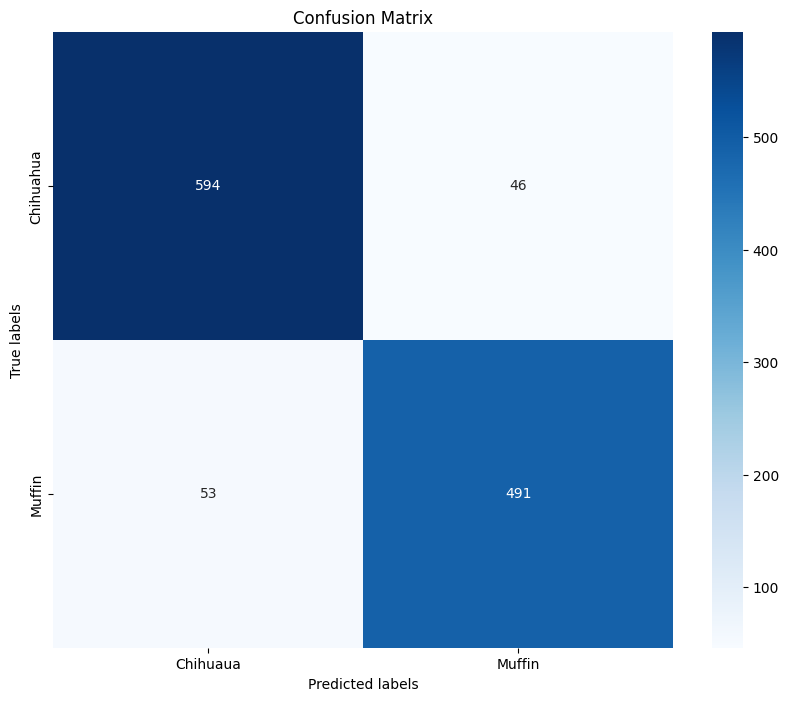

In [20]:
from sklearn.metrics import confusion_matrix

y_pred_labelsf = np.round(y_predf).astype(int).reshape(-1)
conf_matf = confusion_matrix(y_test, y_pred_labelsf)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matf, annot=True, cmap='Blues', fmt='g', xticklabels=['Chihuaua', 'Muffin'], yticklabels=['Chihuahua', 'Muffin'])
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

# **5-fold Cross Validation**

In [17]:
accuracy_list=[]
zero_one_loss_list=[]

k_fold=KFold(n_splits=5, shuffle=True, random_state=42)
index=1
for train_index,test_index in k_fold.split(X_train):
  #subset the training into training and validation
  X_train_cv, X_val_cv = X_train[train_index],X_train[test_index]
  y_train_cv, y_val_cv = y_train[train_index],y_train[test_index]

  print("\n Cycle nr: " + str(index))

  learning_rate_t = 0.0005
  l2_lambda = 0.0001

  modelcv=Sequential()
  modelcv.add(Conv2D(32,(3,3),activation="relu", padding="same", kernel_regularizer=regularizers.l2(l2_lambda),input_shape=(150,150,1)))
  modelcv.add(MaxPooling2D(2,2))


  modelcv.add(Conv2D(32,(3,3),activation="relu",padding="same", kernel_regularizer=regularizers.l2(l2_lambda)))
  modelcv.add(MaxPooling2D(2,2))

  modelcv.add(Conv2D(64,(3,3),activation="relu", padding="same", kernel_regularizer=regularizers.l2(l2_lambda)))
  modelcv.add(MaxPooling2D(2,2))

  modelcv.add(Conv2D(64,(3,3),activation="relu", padding="same", kernel_regularizer=regularizers.l2(l2_lambda)))
  modelcv.add(MaxPooling2D(2,2))

  modelcv.add(Conv2D(128,(3,3),activation="relu", padding="same", kernel_regularizer=regularizers.l2(l2_lambda)))
  modelcv.add(MaxPooling2D(2,2))
  modelcv.add(Dropout(0.6))

  modelcv.add(Conv2D(128,(3,3),activation="relu", padding="same", kernel_regularizer=regularizers.l2(l2_lambda)))
  modelcv.add(MaxPooling2D(2,2))
  modelcv.add(Dropout(0.6))

  modelcv.add(Flatten())


  modelcv.add(Dense(128, activation="relu", kernel_regularizer=regularizers.l2(l2_lambda)))
  modelcv.add(Dropout(0.7))

  modelcv.add(Dense(64, activation="relu", kernel_regularizer=regularizers.l2(l2_lambda)))

  modelcv.add(Dense(32, activation="relu", kernel_regularizer=regularizers.l2(l2_lambda)))

  modelcv.add(Dense(1,activation="sigmoid"))

  modelcv.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=learning_rate_t), metrics=["accuracy"])

  hist = modelcv.fit(
  x=X_train_cv,
  y=y_train_cv,
  epochs=60,
  batch_size=64,
  validation_data=(X_val_cv, y_val_cv),
  shuffle=True,
  callbacks=[early_stopping]
  )

  loss,accuracy = modelcv.evaluate(X_val_cv,y_val_cv)
  zero_one_loss = 1-accuracy
  zero_one_loss_list.append(zero_one_loss)
  accuracy_list.append(accuracy)

  index+=1

print('0-1 Losses:',zero_one_loss_list)
avg_loss = np.mean(zero_one_loss_list)
print("Zero-One Loss: {}".format(avg_loss))
print('Accuracies:',accuracy_list)
avg_acc = np.mean(accuracy_list)
print("AVG Accuracy: {}".format(avg_acc))


 Cycle nr: 1
Epoch 1/60
60/60 [==============================] - 13s 83ms/step - loss: 0.7543 - accuracy: 0.5353 - val_loss: 0.7473 - val_accuracy: 0.5374
Epoch 2/60
60/60 [==============================] - 3s 56ms/step - loss: 0.7436 - accuracy: 0.5380 - val_loss: 0.7411 - val_accuracy: 0.5374
Epoch 3/60
60/60 [==============================] - 3s 53ms/step - loss: 0.7394 - accuracy: 0.5401 - val_loss: 0.7362 - val_accuracy: 0.5374
Epoch 4/60
60/60 [==============================] - 3s 54ms/step - loss: 0.7292 - accuracy: 0.5401 - val_loss: 0.7140 - val_accuracy: 0.5374
Epoch 5/60
60/60 [==============================] - 3s 55ms/step - loss: 0.6991 - accuracy: 0.5290 - val_loss: 0.7348 - val_accuracy: 0.4626
Epoch 6/60
60/60 [==============================] - 3s 58ms/step - loss: 0.7343 - accuracy: 0.5266 - val_loss: 0.7314 - val_accuracy: 0.5374
Epoch 7/60
60/60 [==============================] - 3s 55ms/step - loss: 0.7300 - accuracy: 0.5356 - val_loss: 0.7283 - val_accuracy: 0.537


*   **Average Accuracy: 90.2%**
*   **Average Zero-One Loss: 0.098**